# Comp551 Mini-Project 2 - 20 News Dataset

# **1. Acquire, preprocess, and analyze the data**

In [7]:
import pandas as pd
import numpy as np
# Set the seed for reproducibility (initializes the random number generator)
np.random.seed(500)

### **1.1 Prep work: Downloading necessary files and remove unneeded columns**


#### **1.1.1 Download and import data**

Load the 20 news groups data from sklearn

In [8]:
from sklearn.datasets import fetch_20newsgroups

#Use the default train subset (subset=‘train’, and remove=([‘headers’, ‘footers’, ‘quotes’]) in sklearn.datasets) to train the models
twenty_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
twenty_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

news_group = twenty_train['target_names']


#### **1.1.2 Convert to dataframe**

In [9]:
# convert to panda dataframe for preprocessing
twenty_train = pd.DataFrame({'text': twenty_train.data, 'target': twenty_train.target})
print(twenty_train.shape)
twenty_test = pd.DataFrame({'text': twenty_test.data, 'target': twenty_test.target})
print(twenty_test.shape)
twenty_train.rename(columns = {'target' : 'label'}, inplace = True)
twenty_test.rename(columns = {'target' : 'label'}, inplace = True)
display(twenty_train.head())
display(twenty_test.head())

(11314, 2)
(7532, 2)


,text,label
0,I was wondering if anyone out there could enli...,7
1,A fair number of brave souls who upgraded thei...,4
2,"well folks, my mac plus finally gave up the gh...",4
3,\nDo you have Weitek's address/phone number? ...,1
4,"From article <C5owCB.n3p@world.std.com>, by to...",14


,text,label
0,I am a little confused on all of the models of...,7
1,I'm not familiar at all with the format of the...,5
2,"\nIn a word, yes.\n",0
3,\nThey were attacking the Iraqis to drive them...,17
4,\nI've just spent two solid months arguing tha...,19


### **1.2 Data Preprocessing**

#### **1.2.1 Import relevant packages**

In [10]:
from nltk import pos_tag, word_tokenize          
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [11]:
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stop_words = stopwords.words('english')

#### **1.2.2 Begin prepreprocessing data**

In [12]:
import re
import string

# Lemmatize and Tokenize
def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in tokenizer.tokenize(text.lower())])

# Remove stopwords
def remove_stopwords(text):
  return ' '.join([word for word in text.split() if word not in (stop_words)])

# Remove numbers
alphanumeric = lambda x: re.sub(r"""\w*\d\w*""", ' ', x)
strip = lambda x: " ".join(str.rsplit(x))

# Remove punctuations
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

twenty_train['text'] = twenty_train['text'].apply(lemmatize_text)
twenty_train['text'] = twenty_train['text'].apply(remove_stopwords)
twenty_train['text'] = twenty_train.text.map(alphanumeric).map(strip)
twenty_train['text'] = twenty_train['text'].apply(remove_punctuations)

twenty_test['text'] = twenty_test['text'].apply(lemmatize_text)
twenty_test['text'] = twenty_test['text'].apply(remove_stopwords)
twenty_test['text'] = twenty_test.text.map(alphanumeric).map(strip)
twenty_test['text'] = twenty_test['text'].apply(remove_punctuations)

### **1.3 Statistical Analysis**

#### **1.3.1 Positive + negative distributions**

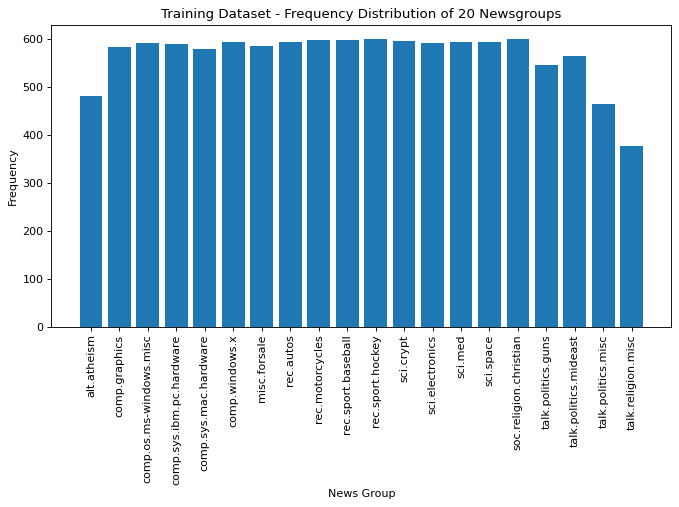

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [13]:
# Finding frequency of each category
label, frequency = np.unique(twenty_train.label, return_counts=True)

# Training data class distribution
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(np.array(news_group),frequency)
plt.xticks(rotation=90)
plt.title('Training Dataset - Frequency Distribution of 20 Newsgroups')
plt.xlabel('News Group')
plt.ylabel('Frequency')
plt.show()
plt.figure()

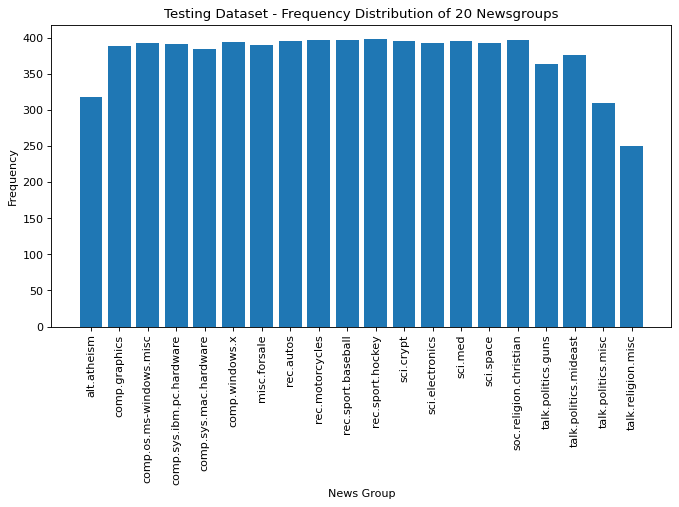

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [14]:
# Finding frequency of each category
label, frequency = np.unique(twenty_test.label, return_counts=True)

# Training data class distribution
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(np.array(news_group),frequency)
plt.xticks(rotation=90)
plt.title('Testing Dataset - Frequency Distribution of 20 Newsgroups')
plt.xlabel('News Group')
plt.ylabel('Frequency')
plt.show()
plt.figure()

### **1.4 Extracting Features**

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [16]:
tfid_vect_twenty = TfidfVectorizer(stop_words='english', min_df=3)
yTrain_twenty = twenty_train.label
yTest_twenty = twenty_test.label
# Vectorize the datasets and use a common vocab to transform the test df
X_tfidf_train = tfid_vect_twenty.fit_transform(twenty_train['text'])
X_tfidf_test = tfid_vect_twenty.transform(twenty_test['text'])

In [40]:
xTrain_20newsOriginal, yTrain_20newsOriginal, xTest_20newsOriginal, yTest_20newsOriginal = X_tfidf_train.toarray(), yTrain_twenty, X_tfidf_test.toarray(), yTest_twenty

In [17]:
from sklearn.calibration import CalibratedClassifierCV
from imblearn.under_sampling import InstanceHardnessThreshold
from sklearn.svm import LinearSVC
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel

def extract_features(xTrain, yTrain, xTest, yTest):
  iht = InstanceHardnessThreshold(random_state=0, n_jobs=11,
                                  estimator=CalibratedClassifierCV(
                                      LinearSVC(C=100, penalty='l1', max_iter=500, dual=False)
                                  ))
  X_resampled, y_resampled = iht.fit_resample(xTrain, yTrain)
  print(sorted(Counter(y_resampled).items()))


  X, yTrain = X_resampled, y_resampled
  X_test, y_test = xTest, yTest

  scaler = MinMaxScaler()
  X_norm = scaler.fit_transform(X.toarray())
  X_test_norm = scaler.transform(X_test.toarray())

  xTrainOriginal = X_norm
  yTrainOriginal = y_resampled
  xTestOriginal = X_test_norm
  yTestOriginal = yTest



  lsvc = LinearSVC(C=100, penalty='l1', max_iter=500, dual=False)
  lsvc.fit(X_resampled, y_resampled)
  fs = SelectFromModel(lsvc, prefit=True)
  X_selected = fs.transform(X_norm)
  X_test_selected = fs.transform(X_test_norm)


  xTrain = X_selected
  xTest = X_test_selected


  print("New dataset shape: ", xTrain.shape)
  print("Original amount of features: ", xTrainOriginal.shape[1])
  print("Current amount of features: ", xTrain.shape[1])
  print("Features reducted: ",xTrainOriginal.shape[1] - xTrain.shape[1])

  return xTrain, xTest, yTrain, yTest

In [18]:
xTrain_20newsReduced, xTest_20newsReduced, yTrain_20newsReduced, yTest_20newsReduced = extract_features(X_tfidf_train, yTrain_twenty, X_tfidf_test, yTest_twenty)

[(0, 377), (1, 377), (2, 377), (3, 377), (4, 377), (5, 377), (6, 377), (7, 377), (8, 377), (9, 377), (10, 377), (11, 377), (12, 377), (13, 377), (14, 377), (15, 377), (16, 377), (17, 377), (18, 377), (19, 377)]


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


New dataset shape:  (7540, 4375)
Original amount of features:  20609
Current amount of features:  4375
Features reducted:  16234


In [19]:
print(tfid_vect_twenty.get_feature_names_out())

['aa' 'aaa' 'aamir' ... 'zy' 'zyxel' 'zz']


# **2. Implement the Models**

In [20]:
import numpy as np
import itertools
%matplotlib inline
import matplotlib.pyplot as plt

### **2.1 Naive Bayes Model**




In [21]:
class MultinomialNB(object):
    # set alpha to be 1 by default
    def __init__(self, alpha):
        self.alpha = alpha

    def fit(self, X, y):
        # count number of data points or samples
        count_sample = X.shape[0]
        # Check each class and count 
        classes = [[x for x, t in zip(X, y) if t == c] for c in np.unique(y)]
        # Calculate the prior
        self.class_log_prior_ = [np.log(len(i) / count_sample) for i in classes]
        # calculate count of each word for each class and add self.alpha as smoothing
        count = np.array([np.array(i).sum(axis=0) for i in classes]) + self.alpha
        # calculate the log probability of each word
        self.feature_log_prob_ = np.log(count / count.sum(axis=1)[np.newaxis].T)
        return self

    def predict_log_proba(self, X):
        return [(self.feature_log_prob_ * x).sum(axis=1) + self.class_log_prior_
                for x in X]

    def predict(self, X):
        # maximize probability
        return np.argmax(self.predict_log_proba(X), axis=1)

### **2.2 K-Fold Cross Validation**

In [22]:
def cross_validate(n, n_folds=10):
    #get the number of data samples in each split
    n_val = n // n_folds
    inds = np.random.permutation(n)
    inds = []
    for f in range(n_folds):
        tr_inds = []
        #get the validation indexes
        val_inds = list(range(f * n_val, (f+1)*n_val))
        #get the train indexes
        if f > 0:
            tr_inds = list(range(f*n_val))
        if f < n_folds - 1:
            tr_inds = tr_inds + list(range((f+1)*n_val, n))
        #The yield statement suspends function’s execution and sends a value back to the caller
        #but retains enough state information to enable function to resume where it is left off
        yield tr_inds, val_inds

# evaluate accuracy
def evaluate_acc(y_pred, y_true):
    # returns the mean accuracy
    count = 0
    for i in range(len(y_pred)):
        if y_pred.tolist()[i] == y_true.tolist()[i]:
            count+=1
    return count/len(y_pred) 

def kfoldCV(x, y, model, n_folds):
  result = 0
  total_x = np.array(x).shape[0]
  for f, (tr, val) in enumerate(cross_validate(total_x, n_folds)):
    x_train = np.array(x)[tr]
    y_train = np.array(y)[tr]
    x_val = np.array(x)[val]
    y_val = np.array(y)[val]
    model = model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    result += evaluate_acc(y_pred, y_val)
  return result / n_folds
    

###**2.3 Hyper-parameter tuning and model selection**

Best Alpha Value: 0.001
Highest accuracy: 0.09814323607427056


Text(0.5, 1.0, 'Variation of 5 Fold Cross Validation Acc as a Function of Alpha')

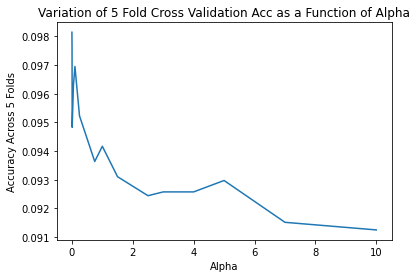

In [23]:
alpha = np.array([0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 1.5, 2.5, 3, 4, 5, 7, 10], dtype=np.float_)
accuracy_list= []
max_acc = 0
best_alpha = 0
for a in alpha:
  model = MultinomialNB(alpha=a)
  acc = kfoldCV(xTrain_20newsReduced, yTrain_20newsReduced, model, 5)
  if acc > max_acc:
    max_acc = acc
    best_alpha = a
  accuracy_list.append(acc)
  

# plot the results as 
data = {'alpha': alpha, '5 fold accuracy': accuracy_list}
print("Best Alpha Value:", best_alpha)
print("Highest accuracy:", max_acc)
plt.plot(alpha,accuracy_list)
plt.ylabel('Accuracy Across 5 Folds')
plt.xlabel('Alpha')
plt.title('Variation of 5 Fold Cross Validation Acc as a Function of Alpha')

In [24]:
best_model = MultinomialNB(alpha=best_alpha)
best_model.fit(xTrain_20newsReduced, yTrain_20newsReduced)
print("Training Accuracy with best model:", evaluate_acc(best_model.predict(xTrain_20newsReduced), yTrain_20newsReduced))
print("Test accuracy with best model:", evaluate_acc(best_model.predict(xTest_20newsReduced), yTest_20newsReduced))

Training Accuracy with best model: 0.9907161803713528
Test accuracy with best model: 0.6178969729155602


The best alpha value for Multinomial Naive Bayes is **0.1**

This produced a best prediction accuracy of **76.87%**

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
# softmax regression 
model = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', max_iter=550, n_jobs=-1)
param_grid = {'C': [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 2.5, 3, 5, 7, 10, 12, 15, 17, 20, 30, 40, 50, 60, 65, 70, 75, 80, 90, 100]}
grid = GridSearchCV(model, param_grid, cv=5)
grid.fit(xTrain_20newsReduced, yTrain_20newsReduced)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print(grid.best_estimator_)

Best cross-validation score: 0.92
Best parameters:  {'C': 12}
LogisticRegression(C=12, max_iter=550, multi_class='multinomial', n_jobs=-1)


The best C value for Logistic Regression is **75**

This produced a best prediction accuracy of **96%**

# **3. Run Experiments**

###**3.1 Performing Naive Bayes and Logistic Regression Classification**

**Define best hyperparameters**

In [45]:
best_alpha =best_alpha
best_C = grid.best_params_['C']

### **3.1.1 Naive Bayes**

In [34]:
best_modelNB = MultinomialNB(alpha=best_alpha)
best_modelNB.fit(xTrain_20newsReduced, yTrain_20newsReduced)
trainingAcc_NB = evaluate_acc(best_modelNB.predict(xTrain_20newsReduced),  yTrain_20newsReduced)
print("Training Accuracy with NB best model:", trainingAcc_NB)
testingAcc_NB = evaluate_acc(best_modelNB.predict(xTest_20newsReduced), yTest_20newsReduced)
print("Test Accuracy with best NB model:", testingAcc_NB)

Training Accuracy with NB best model: 0.9872679045092838
Test Accuracy with best NB model: 0.63688263409453


#### **3.1.2 Logistic Regression**

In [35]:
best_modelLG = grid.best_estimator_
best_modelLG.fit(xTrain_20newsReduced, yTrain_20newsReduced)
trainingAcc_LG = evaluate_acc(best_modelLG.predict(xTrain_20newsReduced),  yTrain_20newsReduced)
print("Training Accuracy with best LR model:", trainingAcc_LG)
testingAcc_LG = evaluate_acc(best_modelLG.predict(xTest_20newsReduced), yTest_20newsReduced)
print("Test accuracy with best LR model:", testingAcc_LG)

Training Accuracy with best LR model: 1.0
Test accuracy with best LR model: 0.6206850770047796


### **3.2 Compare performance of models**

In [36]:
from prettytable import PrettyTable
resultTable = PrettyTable()
resultTable.title = "Best performance of MultinomialNB and Logistic Regression on both testing datasets"
resultTable.field_names = [" ", "20 news group"]


resultTable.add_row(['MultinomialNB - Training Accuracy', trainingAcc_NB])
resultTable.add_row(['MultinomialNB - Testing Accuracy', testingAcc_NB])
resultTable.add_row(['Logistic Regression - Training Accuracy', trainingAcc_LG])
resultTable.add_row(['Logistic Regression - Testing Accuracy', testingAcc_LG])
print(resultTable)


+------------------------------------------------------------------------------------+
| Best performance of MultinomialNB and Logistic Regression on both testing datasets |
+--------------------------------------------------------+---------------------------+
|                                                        |       20 news group       |
+--------------------------------------------------------+---------------------------+
|           MultinomialNB - Training Accuracy            |     0.9872679045092838    |
|            MultinomialNB - Testing Accuracy            |      0.63688263409453     |
|        Logistic Regression - Training Accuracy         |            1.0            |
|         Logistic Regression - Testing Accuracy         |     0.6206850770047796    |
+--------------------------------------------------------+---------------------------+


### **3.3 Comparing accuracy as function of dataset size**

#### **3.3.1 Naive Bayes**

In [31]:
from sklearn.model_selection import train_test_split
training_size_list = [0.2, 0.4, 0.6, 0.8]

def compare_naive_bayes_acc(x_train, y_train, x_test, y_test):
  acc_list = []
 
  for training_size in training_size_list:
    part_x_train, part_x_test, part_y_train, part_y_test = \
      train_test_split(
          x_train,
          y_train,
          train_size=training_size,
          random_state=42,
          shuffle=True
        )
    
    model = MultinomialNB(best_alpha)
    model.fit(part_x_train, part_y_train)

    y_pred = model.predict(x_test)
    acc = evaluate_acc(y_pred, y_test)
    acc_list.append(acc)
    print("Acc with training_size (%s) = %s\n" % (training_size, acc))
  best_acc  = max(acc_list)
  idx = acc_list.index(best_acc)

  print("Best accuracy training_size with %s = %s\n" % (training_size_list[idx], best_acc))
  return acc_list

Acc with training_size (0.2) = 0.5735528412108338

Acc with training_size (0.4) = 0.6060807222517259

Acc with training_size (0.6) = 0.627854487519915

Acc with training_size (0.8) = 0.6380775358470526

Best accuracy training_size with 0.8 = 0.6380775358470526



<Figure size 432x288 with 0 Axes>

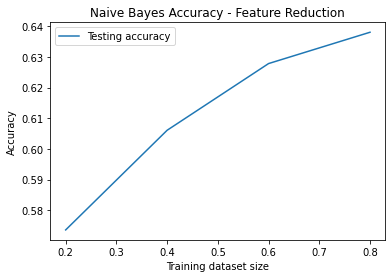

<Figure size 432x288 with 0 Axes>

In [37]:
NB_accList_test1 = compare_naive_bayes_acc(xTrain_20newsReduced, yTrain_20newsReduced, xTest_20newsReduced, yTest_20newsReduced)
# plot 
plt.plot(training_size_list, NB_accList_test1, label ="Testing accuracy")

plt.xlabel('Training dataset size')
plt.ylabel('Accuracy')
plt.title("Naive Bayes Accuracy - Feature Reduction")
plt.legend()
plt.figure()


Acc with training_size (0.2) = 0.6161710037174721

Acc with training_size (0.4) = 0.6603823685608072

Acc with training_size (0.6) = 0.6818906001062135

Acc with training_size (0.8) = 0.6889272437599575

Best accuracy training_size with 0.8 = 0.6889272437599575



<Figure size 432x288 with 0 Axes>

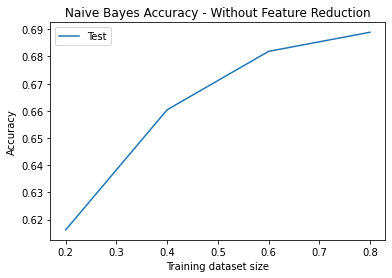

<Figure size 432x288 with 0 Axes>

In [41]:
NB_accList_test2 = compare_naive_bayes_acc(xTrain_20newsOriginal, yTrain_20newsOriginal, xTest_20newsOriginal, yTest_20newsOriginal)

# plot 
plt.plot(training_size_list, NB_accList_test2, label ="Test")

plt.xlabel('Training dataset size')
plt.ylabel('Accuracy')
plt.title("Naive Bayes Accuracy - Without Feature Reduction")
plt.legend()
plt.figure()


#### **3.3.2 Logistic Regression**

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_extraction.text import CountVectorizer
import warnings
from prettytable import PrettyTable

warnings.simplefilter("ignore", category=ConvergenceWarning)

In [43]:
training_size_list = [0.2, 0.4, 0.6, 0.8]
def compare_log_reg_acc(x_train, y_train, x_test, y_test):
  acc_list = []
  
  for training_size in training_size_list:
    # Use percentage of training and testing data
    part_x_train, part_x_test, part_y_train, part_y_test = \
      train_test_split(
          x_train,
          y_train,
          train_size=training_size,
          random_state=42,
          shuffle=True
        )

    lr = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', C=best_C, max_iter=550, n_jobs=-1)
    lr.fit(part_x_train, part_y_train)
    y_hat = lr.predict(x_test)

    acc = evaluate_acc(y_test, y_hat)
    print("Testing accuracy training_size %s = %s\n" % (training_size, acc))
    acc_list.append(acc)

  best_acc  = max(acc_list)
  idx = acc_list.index(best_acc)

  print("Best testing accuracy training_size with %s = %s\n" % (training_size_list[idx], best_acc))
  return acc_list

   

Testing accuracy training_size 0.2 = 0.5469994689325545

Testing accuracy training_size 0.4 = 0.5811205523101434

Testing accuracy training_size 0.6 = 0.6051513542219862

Testing accuracy training_size 0.8 = 0.6127190653212958

Best testing accuracy training_size with 0.8 = 0.6127190653212958



<Figure size 432x288 with 0 Axes>

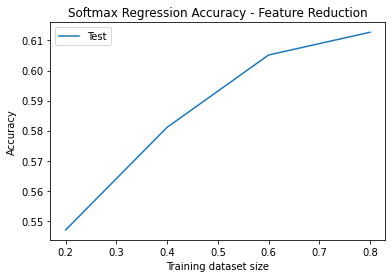

<Figure size 432x288 with 0 Axes>

In [46]:
LR_accList_test1 = compare_log_reg_acc(xTrain_20newsReduced, yTrain_20newsReduced, xTest_20newsReduced, yTest_20newsReduced)
# plot 
plt.plot(training_size_list, LR_accList_test1, label ="Test")

plt.xlabel('Training dataset size')
plt.ylabel('Accuracy')
plt.title("Softmax Regression Accuracy - Feature Reduction")
plt.legend()
plt.figure()


Testing accuracy training_size 0.2 = 0.6190918746680828

Testing accuracy training_size 0.4 = 0.6455124800849708

Testing accuracy training_size 0.6 = 0.661311736590547

Testing accuracy training_size 0.8 = 0.6686139139670738

Best testing accuracy training_size with 0.8 = 0.6686139139670738



<Figure size 432x288 with 0 Axes>

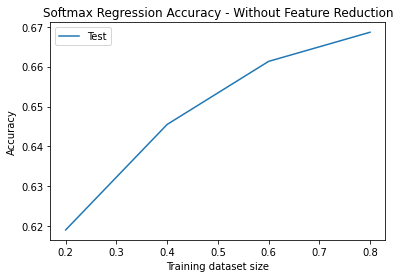

<Figure size 432x288 with 0 Axes>

In [47]:
LR_accList_test2 = compare_log_reg_acc(xTrain_20newsOriginal, yTrain_20newsOriginal, xTest_20newsOriginal, yTest_20newsOriginal)
# plot 
plt.plot(training_size_list, LR_accList_test2, label ="Test")

plt.xlabel('Training dataset size')
plt.ylabel('Accuracy')
plt.title("Softmax Regression Accuracy - Without Feature Reduction")
plt.legend()
plt.figure()

#### **3.3.3 Summary**

In [49]:
from prettytable import PrettyTable
resultTable = PrettyTable()
resultTable.title = "Performance of NB and LR models as functions of dataset size"
resultTable.field_names = [" ", "Dataset Size", "With Feature Reduction", "Without Feature Reduction"]

for i, (NB_FS, NB_WFS) in enumerate(zip(NB_accList_test1, NB_accList_test2)):
  resultTable.add_row(['Multinomial Naive Bayes', training_size_list[i], "{:.2f}%".format(NB_FS*100), "{:.2f}%".format(NB_WFS*100)])

resultTable.add_row(['', '', '', ''])

for i, (LR_FS, LR_WFS) in enumerate(zip(LR_accList_test1, LR_accList_test2)):
  resultTable.add_row(['Logistic Regression', training_size_list[i], "{:.2f}%".format(LR_FS*100), "{:.2f}%".format(LR_WFS*100)])

print(resultTable)

+---------------------------------------------------------------------------------------------+
|                 Performance of NB and LR models as functions of dataset size                |
+-------------------------+--------------+------------------------+---------------------------+
|                         | Dataset Size | With Feature Reduction | Without Feature Reduction |
+-------------------------+--------------+------------------------+---------------------------+
| Multinomial Naive Bayes |     0.2      |         57.36%         |           61.62%          |
| Multinomial Naive Bayes |     0.4      |         60.61%         |           66.04%          |
| Multinomial Naive Bayes |     0.6      |         62.79%         |           68.19%          |
| Multinomial Naive Bayes |     0.8      |         63.81%         |           68.89%          |
|                         |              |                        |                           |
|   Logistic Regression   |     0.2     

### **3.4 Creative Experiment**

####**3.4.1 Count Vectorizer vs TF-IDF Vectorizer**

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfid_vect = TfidfVectorizer(analyzer = "word", max_features=10000, min_df=3)
xTrain = tfid_vect_twenty.fit_transform(twenty_train['text'])
xTest = tfid_vect_twenty.transform(twenty_test['text'])
yTrain = twenty_train.label
yTest = twenty_test.label
yTrain = yTrain
yTest = yTest
xTrain, xTest, yTrain, yTest = extract_features(xTrain, yTrain, xTest, yTest)
nbmodel2 = MultinomialNB(alpha=best_alpha)
lrmodel2 = grid.best_estimator_

lrmodel2.fit(xTrain, yTrain)
acc2 = evaluate_acc(lrmodel2.predict(xTrain),  yTrain)
acc2test = evaluate_acc(lrmodel2.predict(xTest),  yTest)

nbmodel2.fit(xTrain,  yTrain)
acc3 = evaluate_acc(nbmodel2.predict(xTrain),  yTrain)
acc3test = evaluate_acc(nbmodel2.predict(xTest),  yTest)

print()
print('Training accuracy LR with TF-IDF = ', acc2)
print('Test accuracy LR with TF-IDF = ', acc2test)
print('Traing NB with TF-IDF = ', acc3)
print('Test accuracy NB with TF-IDF = ', acc3test)

[(0, 377), (1, 377), (2, 377), (3, 377), (4, 377), (5, 377), (6, 377), (7, 377), (8, 377), (9, 377), (10, 377), (11, 377), (12, 377), (13, 377), (14, 377), (15, 377), (16, 377), (17, 377), (18, 377), (19, 377)]
New dataset shape:  (7540, 4379)
Original amount of features:  20609
Current amount of features:  4379
Features reducted:  16230

Training accuracy LR with TF-IDF =  1.0
Test accuracy LR with TF-IDF =  0.6196229421136484
Traing NB with TF-IDF =  0.986737400530504
Test accuracy NB with TF-IDF =  0.6400690387679235


In [56]:
cv = CountVectorizer(min_df = 3)
cv.fit(twenty_train['text'])
cv_train_data = cv.transform( twenty_train['text'])
cv_test_data = cv.transform( twenty_test['text'])
yTrain = twenty_train.label
yTest = twenty_test.label
xTrain, xTest, yTrain, yTest = extract_features(cv_train_data, yTrain, cv_test_data, yTest)
nbmodel3 = MultinomialNB(alpha=best_alpha)
lrmodel3 = grid.best_estimator_

lrmodel3.fit(xTrain,  yTrain)
acc3=evaluate_acc(lrmodel3.predict(xTrain),  yTrain)
acc3test = evaluate_acc(lrmodel3.predict(xTest),  yTest)

nbmodel3.fit(xTrain,  yTrain)
acc4 = evaluate_acc(nbmodel3.predict(xTrain),  yTrain)
acc4test = evaluate_acc(nbmodel3.predict(xTest),  yTest)

print()
print('Training accuracy LR with Count = ', acc3)
print('Test accuracy LR with Count = ', acc3test)
print('Traing NB with Count = ', acc4)
print('Test accuracy NB with Count = ', acc4test)

[(0, 377), (1, 377), (2, 377), (3, 377), (4, 377), (5, 377), (6, 377), (7, 377), (8, 377), (9, 377), (10, 377), (11, 377), (12, 377), (13, 377), (14, 377), (15, 377), (16, 377), (17, 377), (18, 377), (19, 377)]
New dataset shape:  (7540, 5933)
Original amount of features:  20832
Current amount of features:  5933
Features reducted:  14899

Training accuracy LR with Count =  0.9972148541114059
Test accuracy LR with Count =  0.4920339883165162
Traing NB with Count =  0.9531830238726791
Test accuracy NB with Count =  0.554567180031864


####**3.4.2 The effect of n-grams on accuracy**

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
def n_grams(train, test):

  nbTrain = []
  nbTest = []

  logTrain = []
  logTest = []

  df = [1, 2, 3, 4, 5, 6, 7]

  for num in df:
    tfid_vect_sentiment = TfidfVectorizer(analyzer = "word", max_features=10000, min_df=num)
    xTrain_sentiment = tfid_vect_sentiment.fit_transform(train)

    vocab_sentiment = tfid_vect_sentiment.vocabulary_
    tfid_vect2_sentiment = TfidfVectorizer(vocabulary=vocab_sentiment)
    xTest_sentiment = tfid_vect2_sentiment.fit_transform(test)

    yTrain_sentiment = twenty_train.label
    yTest_sentiment = twenty_test.label
    xTrain_sentiment, xTest_sentiment, yTrain_sentiment, yTest_sentiment= extract_features(xTrain_sentiment, yTrain_sentiment, xTest_sentiment, yTest_sentiment)
    nbmodel2 = MultinomialNB(alpha=best_alpha)
    lrmodel2 = grid.best_estimator_

    lrmodel2.fit(xTrain_sentiment, yTrain_sentiment)
    acc2 = evaluate_acc(lrmodel2.predict(xTrain_sentiment),  yTrain_sentiment)
    logTrain.append(acc2)
    acc2test = evaluate_acc(lrmodel2.predict(xTest_sentiment),  yTest_sentiment)
    logTest.append(acc2test)

    nbmodel2.fit(xTrain_sentiment,  yTrain_sentiment)
    acc3 = evaluate_acc(nbmodel2.predict(xTrain_sentiment),  yTrain_sentiment)
    nbTrain.append(acc3)
    acc3test = evaluate_acc(nbmodel2.predict(xTest_sentiment),  yTest_sentiment)
    nbTest.append(acc3test)

    print()
    print('Training accuracy LR with TF-IDF = ', acc2)
    print('Test accuracy LR with TF-IDF = ', acc2test)
    print('Traing NB with TF-IDF = ', acc3)
    print('Test accuracy NB with TF-IDF = ', acc3test)
    print()

  print("----------Naive Bayes-----------")
  plt.plot(df, nbTrain , '-', label='train')
  plt.plot(df, nbTest , '-', label='test')
  plt.legend()
  plt.xlabel('n-grams number')
  plt.ylabel('accuracy')
  plt.show() 

  print("----------Logistic Regression-----------")
  plt.plot(df, logTrain , '-', label='train')
  plt.plot(df, logTest , '-', label='test')
  plt.legend()
  plt.xlabel('n-grams number')
  plt.ylabel('accuracy')
  plt.show() 

[(0, 377), (1, 377), (2, 377), (3, 377), (4, 377), (5, 377), (6, 377), (7, 377), (8, 377), (9, 377), (10, 377), (11, 377), (12, 377), (13, 377), (14, 377), (15, 377), (16, 377), (17, 377), (18, 377), (19, 377)]
New dataset shape:  (7540, 4049)
Original amount of features:  10000
Current amount of features:  4049
Features reducted:  5951

Training accuracy LR with TF-IDF =  1.0
Test accuracy LR with TF-IDF =  0.6046202867764207
Traing NB with TF-IDF =  0.98342175066313
Test accuracy NB with TF-IDF =  0.6275889537971322

[(0, 377), (1, 377), (2, 377), (3, 377), (4, 377), (5, 377), (6, 377), (7, 377), (8, 377), (9, 377), (10, 377), (11, 377), (12, 377), (13, 377), (14, 377), (15, 377), (16, 377), (17, 377), (18, 377), (19, 377)]
New dataset shape:  (7540, 3991)
Original amount of features:  10000
Current amount of features:  3991
Features reducted:  6009

Training accuracy LR with TF-IDF =  1.0
Test accuracy LR with TF-IDF =  0.6056824216675518
Traing NB with TF-IDF =  0.9830238726790451


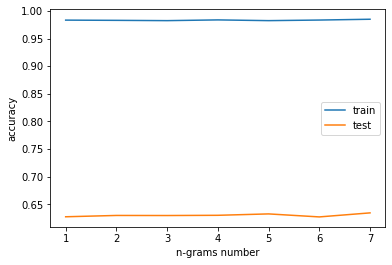

----------Logistic Regression-----------


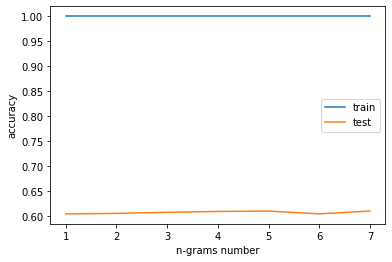

In [61]:
train = twenty_train['text']
test = twenty_test['text']
n_grams(train, test)

####**3.4.3 SVM**

In [65]:
tfid_vect = TfidfVectorizer(analyzer = "word", max_features=10000, min_df=3)
xTrain = tfid_vect_twenty.fit_transform(twenty_train['text'])
xTest = tfid_vect_twenty.transform(twenty_test['text'])
yTrain = twenty_train.label
yTest = twenty_test.label
yTrain = yTrain
yTest = yTest
xTrain, xTest, yTrain, yTest = extract_features(xTrain, yTrain, xTest, yTest)

[(0, 377), (1, 377), (2, 377), (3, 377), (4, 377), (5, 377), (6, 377), (7, 377), (8, 377), (9, 377), (10, 377), (11, 377), (12, 377), (13, 377), (14, 377), (15, 377), (16, 377), (17, 377), (18, 377), (19, 377)]
New dataset shape:  (7540, 4343)
Original amount of features:  20609
Current amount of features:  4343
Features reducted:  16266


In [66]:
from sklearn.svm import SVC

svclassifier = SVC(kernel='linear')
svclassifier.fit(xTrain, yTrain)
y_pred = svclassifier.predict(xTest)
acc1 = evaluate_acc(y_pred,  yTest)
print(acc1)

0.5848380244291025


In [67]:
svclassifier = SVC(kernel='poly')
svclassifier.fit(xTrain, yTrain)
y_pred = svclassifier.predict(xTest)
acc2 = evaluate_acc(y_pred,  yTest)
print(acc2)

0.31664896441848117


In [68]:
svclassifier = SVC(kernel='rbf')
svclassifier.fit(xTrain, yTrain)
y_pred = svclassifier.predict(xTest)
acc3 = evaluate_acc(y_pred,  yTest)
print(acc3)

0.5639936271906533
